# **Generative Adversarial Networks (GAN)**

## **Libraries**

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [4]:
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 128
LATENT_DIM = 75
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1

In [5]:
for x in IMG_SHAPE:
    IMG_SIZE *= x

## **MNIST dataset**

In [6]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Building the model**

In [9]:
class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [10]:
torch.manual_seed(random_seed)

In [11]:
model = GAN()
model = model.to(device)

In [12]:
optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

## **Training phase**

In [13]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        
        # train generator
        
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        discr_pred = model.discriminator_forward(generated_features)
        
        gener_loss = F.binary_cross_entropy(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # train discriminator
        
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss)
        gener_costs.append(gener_loss)
        
        
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Gen/Dis Loss: 0.6566/0.7171
Epoch: 001/010 | Batch 100/469 | Gen/Dis Loss: 5.8731/0.0299
Epoch: 001/010 | Batch 200/469 | Gen/Dis Loss: 1.6986/0.1148
Epoch: 001/010 | Batch 300/469 | Gen/Dis Loss: 1.3255/0.1833
Epoch: 001/010 | Batch 400/469 | Gen/Dis Loss: 2.6374/0.0543
Time elapsed: 0.39 min
Epoch: 002/010 | Batch 000/469 | Gen/Dis Loss: 1.5301/0.2470
Epoch: 002/010 | Batch 100/469 | Gen/Dis Loss: 2.7525/0.0931
Epoch: 002/010 | Batch 200/469 | Gen/Dis Loss: 2.3807/0.3148
Epoch: 002/010 | Batch 300/469 | Gen/Dis Loss: 0.7102/0.4951
Epoch: 002/010 | Batch 400/469 | Gen/Dis Loss: 1.2647/0.3844
Time elapsed: 0.76 min
Epoch: 003/010 | Batch 000/469 | Gen/Dis Loss: 1.6014/0.3480
Epoch: 003/010 | Batch 100/469 | Gen/Dis Loss: 1.1336/0.3800
Epoch: 003/010 | Batch 200/469 | Gen/Dis Loss: 1.2065/0.3627
Epoch: 003/010 | Batch 300/469 | Gen/Dis Loss: 1.5669/0.4182
Epoch: 003/010 | Batch 400/469 | Gen/Dis Loss: 0.9413/0.4967
Time elapsed: 1.14 min
Epoch: 004/010 |

In [14]:
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Total Training Time: 3.83 min


## **Evaluation**

/tmp/ipykernel_3528/2534235671.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(newlabel[::10])


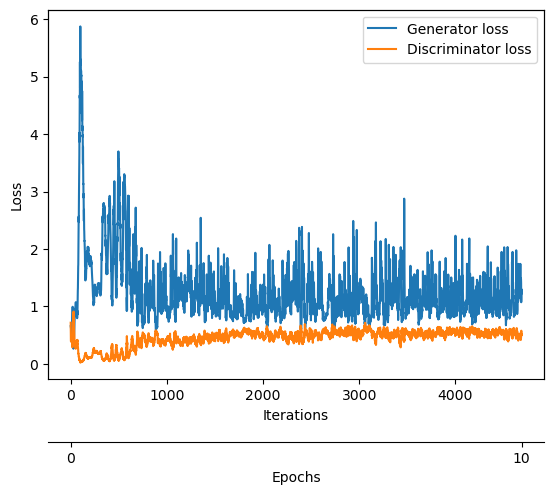

In [21]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), [g.detach().item() for g in gener_costs], label='Generator loss')
ax1.plot(range(len(discr_costs)), [d.detach().item() for d in discr_costs], label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
plt.show()

In [22]:
model.eval()

GAN(
  (generator): Sequential(
    (0): Linear(in_features=75, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=784, bias=True)
    (4): Tanh()
  )
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

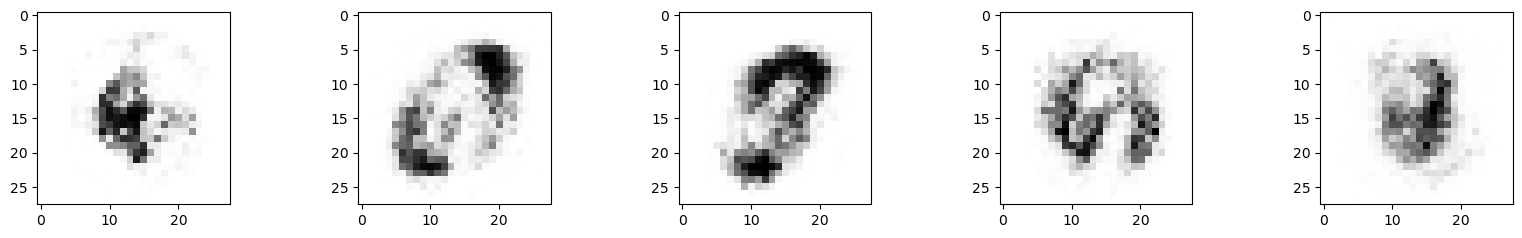

In [23]:
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')